In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Let's load the first data with 2 dimensions

In [2]:
from scipy.io import loadmat

ex8 = loadmat('../Anomaly_detection/Data/ex8data1.mat')
twoD = ex8['X']

#This is the test data that we'll verify our model with
xval = ex8['Xval']
yval = ex8['yval']

<IPython.core.display.Javascript object>


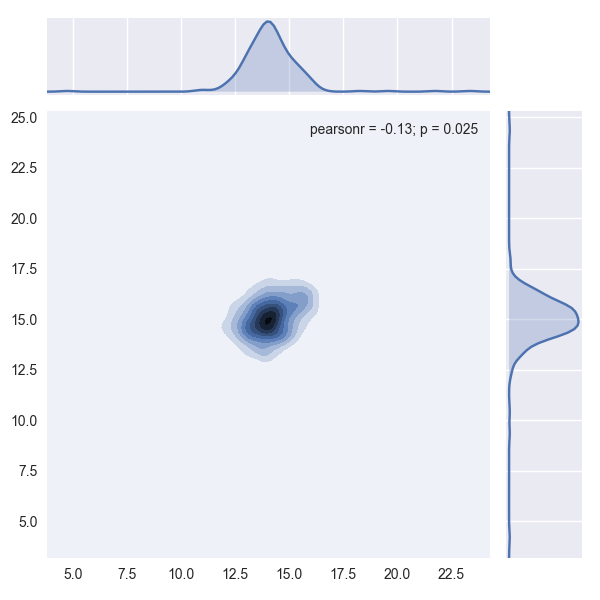

<IPython.core.display.Javascript object>


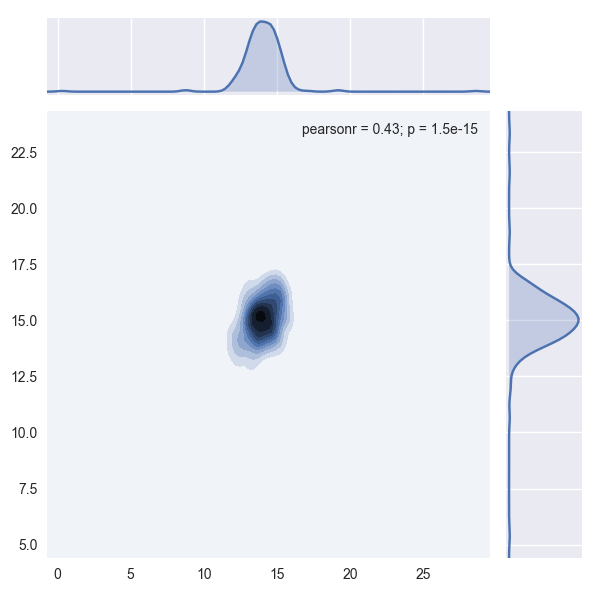

In [3]:
#let's visualise the data
import seaborn as sns

_ = sns.jointplot(x=twoD[:, 0], y=twoD[:, 1], kind='kde')

_ = sns.jointplot(x=xval[:, 0], y=xval[:, 1], kind='kde')


Both data, train and test are normally distributed, so the anomaly distribution will work well on them

In [4]:
from scipy.stats import multivariate_normal

def fit_gauss(x):
    '''This method will calculate the mean for all the features,
    and a covariance matrix'''
    
    mu = x.mean(axis=0)
    cov = np.cov(x.T)
    return mu, cov

def mulvar_gauss(x, mu, cov):
    '''This method will accept a numpy array along with mean vector
    and its covariance matrix'''
    
    g = multivariate_normal(mean=mu, cov=cov)
    return g.pdf(x)

In [5]:
from sklearn.metrics import f1_score

def sel_epsilon_1(pval,yval):
    '''Select the epsilon(threshold) corresponding to the best F1 score
    on this data.
    Note: Anomaly detection can be considered as a highly skewed binary classification
    example, that's why we use the F1 metric'''
    
    f1 = []
    stepsize = (max(pval) - min(pval)) / 1000;
    epsilons = np.arange(min(pval),max(pval),stepsize) #get an array of real numbers from which we select the epsilon
    
    '''loop over epsilons array, call f1score method with yreal=yval and ypred=(pval<epsilon),
    and append a tuple (f1, epsilon) to the list f1'''
    
    f1 = np.asarray([(f1_score(yval,(pval < epsilon),average='binary'), epsilon) for epsilon in np.nditer(epsilons)])
    max1 = np.argmax(f1, axis=0) #Get the index at max value of F1(axis=0)
    
    #return the best f1 score along with the epsilon
    return f1[max1[0], :]

In [6]:
def sel_epsilon_2(pval,yval):
    '''select epsilon implemented without vectorization and numpy
    to check efficiency'''
    
    best_epsilon = 0
    best_f1 = 0
    #f1 = []
    stepsize = (max(pval) - min(pval)) / 1000;
    epsilons = np.arange(min(pval),max(pval),stepsize)
    
    #implemented using python loops
    
    for epsilon in np.nditer(epsilons):
        predictions = (pval < epsilon) 
        f = f1_score(yval, predictions,average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

In [7]:
'''We'll fit the twoD data now, get its mean and cov, call mulvar_gauss method
to return the PDF for the test data.
Also, check whether the numpy vectorized implementation is faster'''

mu, cov = fit_gauss(twoD)
pval = mulvar_gauss(xval, mu, cov)
%time epsilon, f1 = sel_epsilon_1(pval, yval) 
%time epsilon, f1 = sel_epsilon_2(pval, yval) 


/Users/harshit/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 710 ms, sys: 14.6 ms, total: 724 ms
Wall time: 564 ms
CPU times: user 468 ms, sys: 4.37 ms, total: 473 ms
Wall time: 476 ms


In [8]:
#fitting our data

f1, epsilon = sel_epsilon_1(pval, yval) 
outliers = np.where(pval<epsilon) #outliers' index for p(x) less than epsilon

print(epsilon, f1)

(9.0362406761563857e-05, 0.87500000000000011)


# Plot the data along with detected anomalies in red

<IPython.core.display.Javascript object>


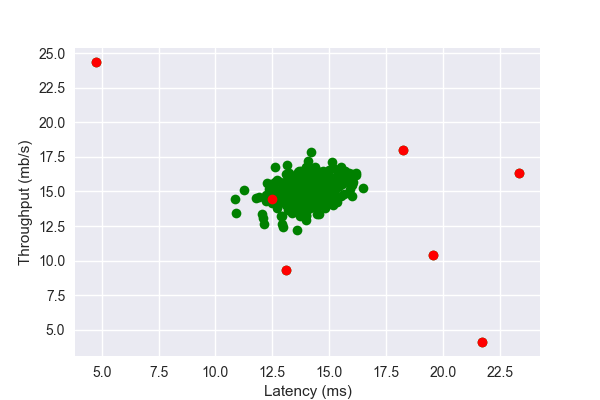

In [9]:

plt.figure(figsize=(6, 4)) 
plt.xlabel("Latency (ms)") 
plt.ylabel("Throughput (mb/s)") 
_= plt.plot(twoD[:,0],twoD[:,1],"go")
_= plt.plot(twoD[outliers,0],twoD[outliers,1],"ro") 


# Since our code was written in a vectorized form, we can check it with a high dimensional data (1000, 11)


In [10]:
highD = loadmat('../Anomaly_detection/Data/ex8data2.mat')
hd = highD['X']
xval1 = highD['Xval']
yval1 = highD['yval']

mu1, cov1 = fit_gauss(hd)
pval1 = mulvar_gauss(xval1, mu1, cov1)
f1, epsilon = sel_epsilon_1(pval1, yval1) 
f1, epsilon

(0.55172413793103448, 1.7464996396712342e-18)